This notebook trains an A2C algorithm on discrete environments. This one is setup for OpenAI Gym's Cart Pole, but can be easily modified for environments. Note that some dependencies are their older versions, but are used for the sake of running their old operations and compatability with each other. Namely, gym is oudated and gymnasium is the newer version being updated.

## Imports

In [1]:
import os
import torch # --------------------- v1.6.0
import gym # ----------------------- v0.25.2
import numpy as np #  -------------- v1.24.4
import matplotlib.pyplot as plt # -- v3.6.2
from tqdm import tqdm # ------------ v4.65.0
from torch import nn as nn
from torch.optim import AdamW
import torch.nn.functional as F

from parallel_env import ParallelEnv, ParallelWrapper # helper file

## Helper functions

In [2]:
def seed_everything(env: gym.Env, seed: int = 42) -> None:
    """
    Seeds all the sources of randomness so that experiments are reproducible.
    Args:
        env: the environment to be seeded.
        seed: an integer seed.
    Returns:
        None.
    """
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch._set_deterministic(True)

In [3]:
def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()

## Create and preprocess the environment

### Create the environment

In [4]:
env_name = 'CartPole-v1'

In [5]:
env = gym.make(env_name, render_mode="human")

/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: 4. Actions: 2
Sample state: [-0.0375263  -0.01657907  0.02936944 -0.02467945]


### Parallelize the environment

In [7]:
num_envs = os.cpu_count()

In [8]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    seed_everything(env)
    return env

In [9]:
env_fns = [lambda: create_env(env_name, seed=rank) for rank in range(num_envs)]
parallel_env = ParallelEnv(env_fns)

/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


### Prepare the environment to work with PyTorch

In [10]:
class PreprocessEnv(ParallelWrapper):
    
    def __init__(self, env):
        ParallelWrapper.__init__(self, env)
    
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()
    
    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
     
    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [11]:
parallel_env = PreprocessEnv(parallel_env)

### Create the policy $\pi(s)$

In [12]:
policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(), 
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1) # [-inf, inf] -> [0, 1]
)

### Create the value network $v(s)$

In [13]:
value_net = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(), 
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1) # [-inf, inf]
)

## Implement the algorithm

In [14]:
def A2C(policy, value_net, episodes, alpha=1e-4, gamma=0.99):
    policy_optim = AdamW(policy.parameters(), lr=alpha)
    value_optim = AdamW(value_net.parameters(), lr=alpha)
    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    for episode in tqdm(range(1, episodes + 1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        ep_return = torch.zeros((num_envs, 1))
        I = 1.

        while not done_b.all():
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)

            value = value_net(state)
            target = reward + ~done * gamma * value_net(next_state).detach()
            critic_loss = F.mse_loss(value, target)
            value_net.zero_grad()
            critic_loss.backward()
            value_optim.step()

            advantage = (target-value).detach()
            probs = policy(state)
            log_probs = torch.log(probs + 1e-6)
            action_log_prob = log_probs.gather(1, action)
            entropy = - torch.sum(probs * log_probs, dim=-1, keepdim=True)
            actor_loss = - I * action_log_prob * advantage - 0.01 * entropy
            actor_loss = actor_loss.mean()
            policy.zero_grad()
            actor_loss.backward()
            policy_optim.step()

            ep_return += reward
            done_b |= done
            state = next_state
            I = I * gamma

        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return.mean().item())

    return stats



In [15]:
stats = A2C(policy, value_net, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/isaihbernardo/miniconda3/envs/new/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

## Show results

### Show execution stats

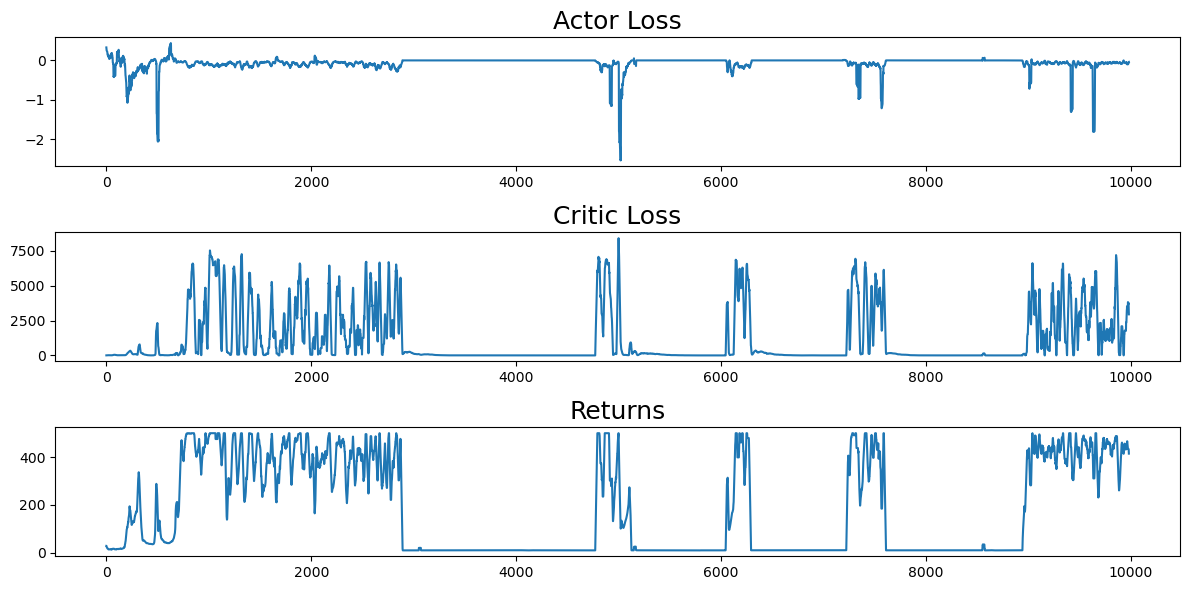

In [16]:
plot_stats(stats)

### Test the resulting agent

In [17]:
def test_policy_network1(env, policy, episodes=1):
    from IPython import display
    plt.figure(figsize=(6, 6))
    for episode in range(episodes):
        state = env.reset()
        done = False
        env.render()
        while not done:
            state = torch.from_numpy(state).unsqueeze(0).float()
            action = policy(state).multinomial(1).item()
            next_state, _, done, _ = env.step(action)
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            state = next_state

 ### Call the test agent function (WIP)

## Close the environment

In [18]:
env.close()